# Setup

In [1]:
#pip install einops

In [2]:
# Modified from https://www.tensorflow.org/text/tutorials/nmt_with_attention
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2023-08-06 17:47:25.030877: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
class ShapeChecker():
  def __init__(self):
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Prepare Dataset

In [4]:
!head parallel_corpus.csv

/bin/bash: /home/ai-server/anaconda3/envs/hmp_tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ကံ က ဆိုး ချင် တော့ နေ စ ရာ အိမ် ရော သူ တို့ နှစ် ယောက် ရဲ့ ချစ် လှ စွာ သော မ ဟေ သီ နှစ် ယောက် ပါ မ တွေ့ တော့ နှစ် ကောင် လုံး ဘုံ ပျောက် ပြီ ပေါ့	ကံ က ဆိုး ချင် တော့ နေ စ ရာ အိမ်် ရော သူ တိို့ နှစ်် ယောက်် ရဲဲ့ ချစ်် လှ စွာ သော မ ဟေ သီီ နှစ်် ယောက်် ပါ မ တွေ့ တော့ နှစ်် ကောင်် လုံး ဘုံ ပျောက်် ပြီီ ပေါ့
ကံ က ဆိုး ချင် တော့ သူ ရိန် မင်း က သူ့ မိန်း မ အ တွယ် တာ က လေး မွေး တဲ့ နေ့ မှာ ဆုံး သွား ပြီ တဲ့	ကံ က ဆိုး ချင် တော့ သူ ရိန် မင်း က သူ့ မိန်း မ အ တွယ် တာ က လေး မွေး တဲ့ နေ့ မှာ ဆုံး သွား ပြီ တဲ့
ကံ ကြမ္မာ က ကျွန် တော် တို့ အောင် မြင် ဖို့ ကျွန် တော် တို့ ကို မျက် နှာ သာ ပေး ခဲ့ တယ်	ကံ ကြမ္မာ က ကျွန် တော် တို့ အောင် မြင် ဖို့ ကျွန် တော် တို့ ကို မျက် နှာ သာ ပေး ခ့ဲ တယ်
ကံ ကြမ္မာ က ကျွန် တော် တို့ အောင် မြင် ဖို့ မျက် နှာ သာ ပေး ခဲ့ တယ်	ကံ့ ကြမ္မာ က ကျွန် တော့် တို့ အောင့် မြင့် ဖို့ မျက် နှာ သာ ပေး ခဲ့ တယ့်
ကံ ကြမ္မာ က ရဲ ရင့် သူ ကို အ ခွင့် အ ရေး ပေး တယ်	ကံ ကြမ္မ

In [5]:
!wc -l parallel_corpus.csv

/bin/bash: /home/ai-server/anaconda3/envs/hmp_tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
297746 parallel_corpus.csv


In [6]:
#shuffle data
!shuf parallel_corpus.csv > parallel_corpus.shuf.csv
!head parallel_corpus.shuf.csv

/bin/bash: /home/ai-server/anaconda3/envs/hmp_tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/ai-server/anaconda3/envs/hmp_tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
မြန် မာ ပြည် တစ် ပြည် လုံး နီး ပါး မြို့ ကြီး ပေါင်း တစ် ရာ့ လေး ဆယ် ကျော် မှာ ပန်း ပို့ ကိုယ် စား လှယ် လေး တွေ ရှိ ပါ တယ်	မြန် မာ ပြည် တစ် ပြည် လုံး နီ ပါ မြို ကြီ ပေါင် တစ် ရာ လေ ဆယ် ကျော် မှာ ပန် ပို ကိုယ် စာ လှယ် လေ တေ ရှိ ပါ တယ်
က လေး နည်း နည်း ကြီး ရင် ရင် ညွန့် ရိုး မှာ တစ် လက် မ အ ထိ အောက် ကျ သွား အောင် ထိ ပါ	က လေး နည်း နည်း ကြီး ရင် ရင် ညွန့် ရုိး မှာ တစ် လက် မ အ ထိ အောက် ကျ သွား အောင် ထိ ပါ
အ ပူ သည် ကိုယ် ထည် များ ကို ကျယ် ပြန့် စေ သ လား	အ ပူ့ သည့် ကိုယ့် ထည့် များ ကို ကျယ် ပြန့် စေ သ လား
ပြဋ္ဌာန်း ထား သော ဥ ပ ဒေ နည်း ဥ ပ ဒေ များ မှ တား မြစ် ချက် တစ် ရပ် ရပ် ကို ဖောက် ဖျက် ကျူး လွန် ပြီး ပြစ် မှု ထင် ရှား ပါ က သုံး နှစ် ထက် မ ပို သော ထောင် ဒဏ် ဖြစ် စေ ငွေ ဒဏ် သုံး သိန်း ဖြစ် စေ ပြစ် ဒဏ် နှစ် ရပ် လုံး ဖြစ် စေ ချ မှတ် ခံ ရ မည် ဖြစ် 

In [7]:
path_to_file = "parallel_corpus.shuf.csv"

In [8]:
from pathlib import Path
def load_data(path):
  path = Path (path)
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [9]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

ကျွန်် တော် တို့ ခင် ဗျား ကို မ ယုံ ခဲ့ လိို့ လား


In [10]:
print(target_raw[-1])

ကျွန် တော် တို့ ခင် ဗျား ကို မ ယုံ ခဲ့ လို့ လား


## Create a tf.data dataset

create a tf.data.Dataset of strings that shuffles and batches them efficiently:

In [11]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 32

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

2023-08-06 17:47:34.732118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 17:47:34.758699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 17:47:34.758853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 17:47:34.759253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

## Text Preprocessing

In [12]:
# standardization
def standardize(text):
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [13]:
# vectorization
max_vocab_size = 15000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=standardize,
    max_tokens=max_vocab_size,
    ragged=True)

In [14]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'အ', '[START]', '[END]', 'ပါ', 'က', 'မ', 'တယ်', 'ကို']

In [15]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=standardize,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'အ', '[START]', '[END]', 'ပါ', 'ကို', 'တယ်', 'က', 'မ']

In [16]:
len(target_text_processor.get_vocabulary())

5179

In [17]:
len(context_text_processor.get_vocabulary())

12044

# Process the dataset

The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit. Keras expects (inputs, labels) pairs, the inputs are the (context, target_in) and the labels are target_out. The difference between target_in and target_out is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [18]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [19]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   3  423   12  162    6  900 2530  248   58    2]

[   3  398   14   10    8  834 1510  214   54    2]
[ 398   14   10    8  834 1510  214   54    2   94]


# Encoder

The encoder: bidirectional RNN

Takes a list of token IDs (from context_text_processor).

Looks up an embedding vector for each token (Using a layers.Embedding).

Processes the embeddings into a new sequence (Using a bidirectional layers.GRU).

Returns the processed sequence. This will be passed to the attention head.

In [20]:
UNITS = 512

In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    x = self.rnn(x)
    shape_checker(x, 'batch s units')
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [22]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (32, 46)
Encoder output, shape (batch, s, units): (32, 46, 512)


2023-08-06 17:47:43.823807: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


# The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

In [23]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [24]:
attention_layer = CrossAttention(UNITS)
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (32, 46, 512)
Target sequence, shape (batch, t, units): (32, 45, 512)
Attention result, shape (batch, t, units): (32, 45, 512)
Attention weights, shape (batch, t, s):    (32, 45, 46)


2023-08-06 17:47:44.045760: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


The attention weights will sum to 1 over the context sequence, at each location in the target sequence.

In [25]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.99999994, 0.99999994, 1.        , 0.9999999 ,
       0.99999994, 0.9999999 , 1.0000001 , 1.        , 1.        ,
       0.9999999 , 1.        , 1.        , 0.9999999 , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

# The decoder

Decoder : unidirectional RNN

The decoder's job is to generate predictions for the next token at each location in the target sequence.

It looks up embeddings for each token in the target sequence.

It uses an RNN to process the target sequence, and keep track of what it has generated so far.

It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.

At each location in the output it predicts the next token.

In [26]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units

    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.attention = CrossAttention(units)

    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [27]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [28]:
decoder = Decoder(target_text_processor, UNITS)

In [29]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (32, 46, 512)
input target tokens shape: (batch, t) (32, 45)
logits shape shape: (batch, target_vocabulary_size) (32, 45, 5179)


# Inference

In [30]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [31]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [32]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  done = done | (next_token == self.end_token)
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [33]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  tokens.append(next_token)


tokens = tf.concat(tokens, axis=-1)

result = decoder.tokens_to_text(tokens)

# The model

In [34]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()

    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [35]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (32, 46)
Target tokens, shape: (batch, t) (32, 45)
logits, shape: (batch, t, target_vocabulary_size) (32, 45, 5179)


# Train

In [36]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [37]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [38]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [39]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.552367, 'expected_acc': 0.00019308746862328635}

That should roughly match the values returned by running a few steps of evaluation:

In [40]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 6s 20ms/step - loss: 8.5539 - masked_acc: 1.3495e-04 - masked_loss: 8.5539


{'loss': 8.553900718688965,
 'masked_acc': 0.00013495275925379246,
 'masked_loss': 8.553900718688965}

In [41]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


2023-08-06 17:48:12.303791: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_22'


100/100 [==============================] - 14s 46ms/step - loss: 5.5318 - masked_acc: 0.1162 - masked_loss: 5.5318 - val_loss: 4.6397 - val_masked_acc: 0.1959 - val_masked_loss: 4.6397
Epoch 2/100
100/100 [==============================] - 4s 45ms/step - loss: 4.3541 - masked_acc: 0.2282 - masked_loss: 4.3541 - val_loss: 4.1435 - val_masked_acc: 0.2547 - val_masked_loss: 4.1435
Epoch 3/100
100/100 [==============================] - 5s 46ms/step - loss: 3.9924 - masked_acc: 0.2712 - masked_loss: 3.9924 - val_loss: 3.8764 - val_masked_acc: 0.2845 - val_masked_loss: 3.8764
Epoch 4/100
100/100 [==============================] - 5s 45ms/step - loss: 3.4108 - masked_acc: 0.3646 - masked_loss: 3.4108 - val_loss: 2.5920 - val_masked_acc: 0.5099 - val_masked_loss: 2.5920
Epoch 5/100
100/100 [==============================] - 5s 45ms/step - loss: 2.0598 - masked_acc: 0.6050 - masked_loss: 2.0598 - val_loss: 1.3541 - val_masked_acc: 0.7338 - val_masked_loss: 1.3541
Epoch 6/100
100/100 [==========

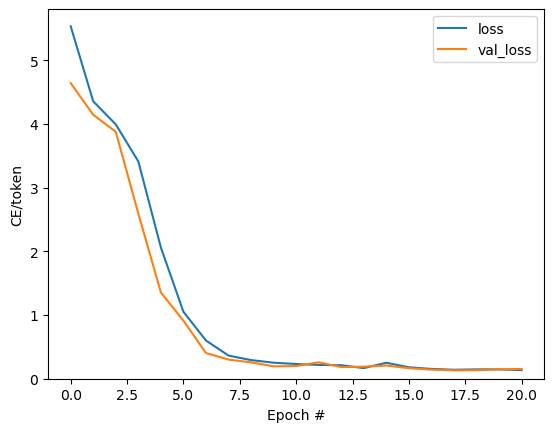

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

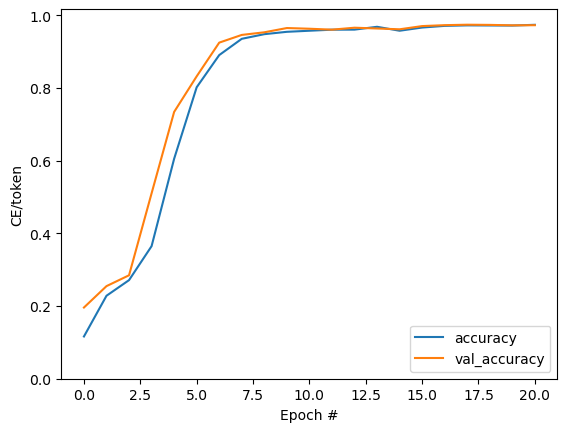

In [43]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Translate

In [44]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=300,
              temperature=0.5):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)
  result = self.decoder.tokens_to_text(tokens)
  return result

In [45]:
inputs = [
    'ဘာ တေ ဖစ် နေ တာ လဲ မ သိ ဝူး',
    'သူ တစ် ယောက် တည်း လည်း အ ဆင် မ ပြေ နိုင် ဘူး',
    'အ လျှော့ ပေး လည်း ပြတ် တဲ့ ကြိုး က ပြတ် တာ ပါ ပဲ',
    'သူ ဘယ် သွား တာ လဲ ရှင်',
    'ဒါ ပေ မဲ့ လည်း အ လျှော့ ပေး ရင်း နဲ့ က ပြတ် တောက် သွား တဲ့ ဆက် ဆံ ရေး တွေ အ ကြောင်း တော့ လူ ဒေ မ သိ တာ များ တယ်',
    'ငါ တို ရှင် သန် ရာ ပတ်် ဝန်း ကျင်',
    'လက် ညှိုး တေ များ ဒယ်',
    'တစ် လှမ်း ချင်း လျှောက် လည်း ရောက် ၇ မယ်',
]

In [46]:
for t in inputs:
    print(model.translate([t])[0].numpy().decode())
print()

ဘာ တွေ ဖြစ် နေ တာ လဲ မ သိ ဘူး 
သူ တစ် ယောက် တည်း လည်း အ ဆင် မ ပြေ နိုင် ဘူး 
အ လျှော့ ပေး လည်း ပြတ် တဲ့ ကြိုး က ပြတ် တာ ပါ ပဲ 
သူ ဘယ် သွား တာ လဲ ရှင် 
ဒါ ပေ မဲ့ လည်း အ လျှော့ ပေး ရင်း နဲ့ က ပြတ် တောက် သွား တဲ့ ဆက် ဆံ ရေး တွေ အ ကြောင်း တော့ လူ တွေ မ သိ တာ များ တယ် 
ငါ တို့ ရှင် သန် ရာ ပတ် ဝန်း ကျင် 
လက် ညှိုး တွေ များ တယ် 
တစ် လှမ်း ချင်း လျှောက် လည်း ရောက် ရ မယ် 



# Export

In [47]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [48]:
export = Export(model)

In [49]:
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets
